## Loading Packages

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
%matplotlib inline
#%matplotlib nbagg

pd.options.display.precision = 15

## Umgebungsvariablen

In [4]:
failure_datapath = '''D:/jupyter-notebooks/LANL_Earthquake_Prediction/failure/'''
train_data_path = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/all/train.csv'''


### Load the full dataset

In [5]:
train_data = pd.read_csv(train_data_path, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

## Acoustic data

In [5]:
train_data.acoustic_data.describe()

count    6.2914548000e+08
mean     4.5194675737e+00
std      1.0735707250e+01
min     -5.5150000000e+03
25%      2.0000000000e+00
50%      5.0000000000e+00
75%      7.0000000000e+00
max      5.4440000000e+03
Name: acoustic_data, dtype: float64

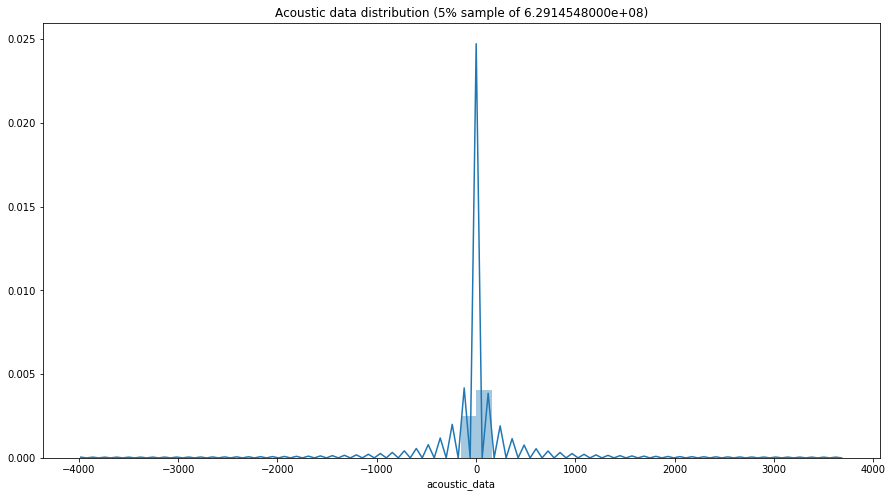

In [21]:
train_sample =train_data.sample(frac=0.05)
plt.figure(figsize=(15,8))
plt.title("Acoustic data distribution (5% sample of 6.2914548000e+08)")
ax = sns.distplot(train_sample.acoustic_data)
#quelle: https://www.kaggle.com/jsaguiar/seismic-data-exploration

Max Value beträgt: 5.4440000000e+03

In [29]:
train_sample.acoustic_data.quantile(0.9)

9.0

90% der accoustic daten liegen unter 9.

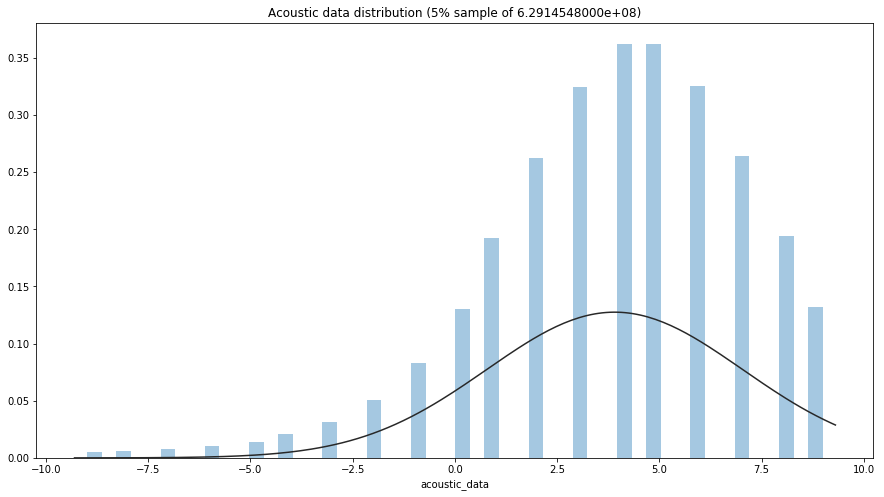

In [31]:
plt.figure(figsize=(15,8))
plt.title("Acoustic data distribution (5% sample of 6.2914548000e+08)")
ax = sns.distplot(train_sample.acoustic_data[train_sample.acoustic_data.between(-9, 9)], kde=False,fit=stats.norm)
#kde = whether to plot a gaussian kernel density estimate.
#quelle: https://www.kaggle.com/jsaguiar/seismic-data-exploration

## Time to failure

In [6]:
train_data.time_to_failure.describe()

count    6.2914548000e+08
mean     5.6782917130e+00
std      3.6726965194e+00
min      9.5503963166e-05
25%      2.6259969961e+00
50%      5.3497977412e+00
75%      8.1733955078e+00
max      1.6107400000e+01
Name: time_to_failure, dtype: float64

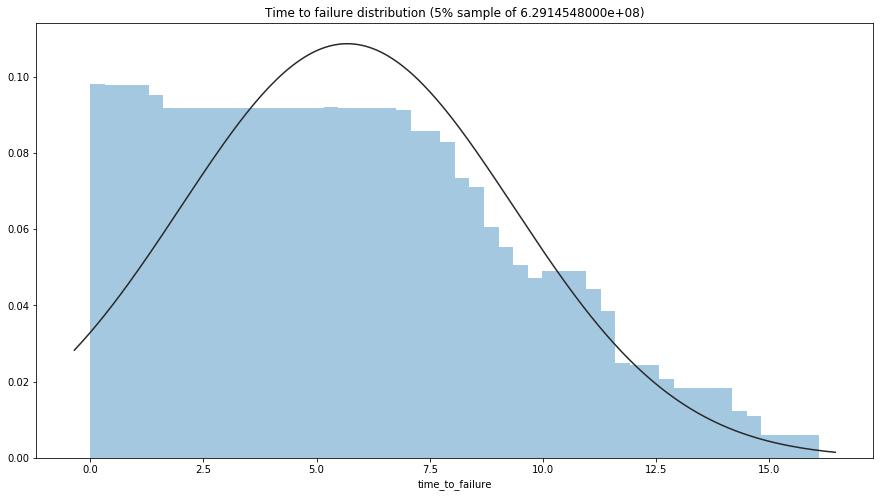

In [35]:
plt.figure(figsize=(15,8))
plt.title("Time to failure distribution (5% sample of 6.2914548000e+08)")
ax = sns.distplot(train_sample.time_to_failure,fit=stats.norm,kde=False )

Die Dauer bis zu einem Erdbeben liegt im Schnitt bei 5 - 7 Sekunden

# Data preparation
Die Trainingsdaten werden in die einzelnen Erdbeben aufgeteilt und je in ein separates File faulure gespeichert

## Die einzelnen Erdbeben voneinander trennen

In [8]:
#diff = a[n+1] - a[n].In case of a slip (time_to_failure near zero) the following number a[n] is higher than a[n+1]
failure_border = np.where(np.diff(train_data.time_to_failure) > 0)

In [9]:
failures = []
start = 0
for end in failure_border[0]:
    failures.append(train_data.iloc[start:end])
    start = end + 1

In [ ]:
for failure in failures:
    print(failure.describe())

### Save each failure to file

In [11]:
for failure in range(0,len(failures)):
    np.save('./failure/failure{}'.format(failure),failures[failure])

### load first earthquake

In [19]:
failure = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(0)))
failure.columns = ['acoustic_data','time_to_failure']

### Reduce datapoints from first earthquake

In [10]:
failure_reduced = failure.iloc[::2, :] #every second element
failure_reduced.reset_index(inplace=True)
failure_reduced.describe()

,index,acoustic_data,time_to_failure
count,2.8282870000e+06,2.8282870000e+06,2.8282870000e+06
mean,2.8282860000e+06,4.5621734994e+00,7.3498310924e-01
std,1.6329125495e+06,2.3429143897e+01,4.2417205919e-01
min,0.0000000000e+00,-4.6210000000e+03,7.9548092344e-04
25%,1.4141430000e+06,2.0000000000e+00,3.6789660732e-01
50%,2.8282860000e+06,5.0000000000e+00,7.3499773262e-01
75%,4.2424290000e+06,7.0000000000e+00,1.1020988579e+00
max,5.6565720000e+06,3.2400000000e+03,1.4690999832e+00


# Plot all earthquakes

In [20]:
def plot_acc_ttf_data(train, final_idx, init_idx=0, step=1, title="",
                      color1='orange', color2='blue'):
    '''quelle: https://www.kaggle.com/jsaguiar/seismic-data-exploration
       train: DataFrame mit column acoustic_data und time_to_failure
       init_idx: start index
       final_idx: end iundex
    '''
    idx = [i for i in range(init_idx, final_idx, step)]
    fig, ax1 = plt.subplots(figsize=(10, 5))
    fig.suptitle(title, fontsize=14)
    
    ax2 = ax1.twinx()
    ax1.set_xlabel('index')
    ax1.set_ylabel('Acoustic data')
    ax2.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=train.iloc[idx].acoustic_data.values, ax=ax1, color=color1)
    p2 = sns.lineplot(data=train.iloc[idx].time_to_failure.values, ax=ax2, color=color2)

<IPython.core.display.Javascript object>


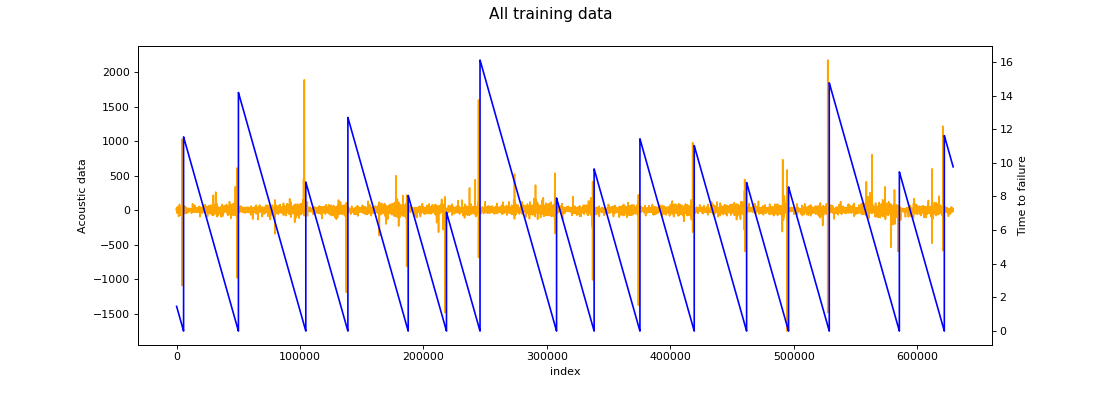

In [7]:
plot_acc_ttf_data(train_data,final_idx=len(train_data), step=1000, title="All training data")

Überprüfung, ob die Aufteilung in die 16 Erdbeben wirklich stimmt

<IPython.core.display.Javascript object>


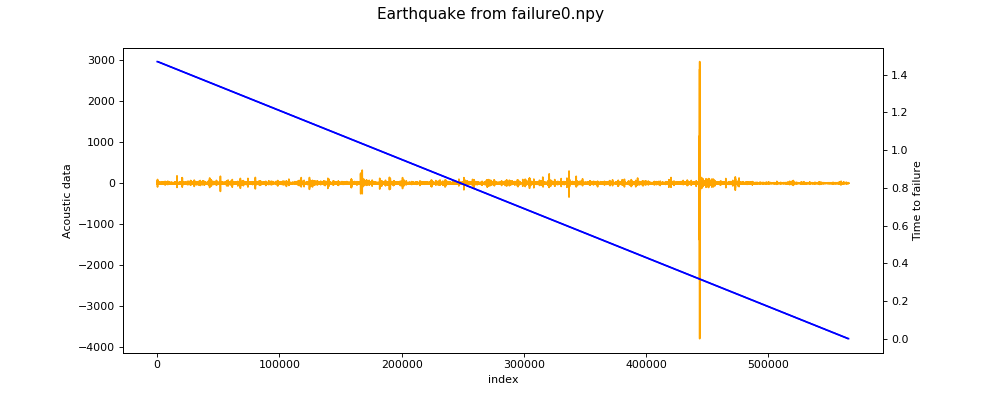

In [21]:
plot_acc_ttf_data(failure,final_idx=len(failure), step=10, title="Earthquake from file failure0.npy")

# Trends and Seasonality

## Augmented Dickey-Fuller test

### Was ist eine stationäre Zeitreihe?

Stationäre Zeitreihen weisen keine systematische Veränderung im Gesamtbild auf, d.h. es bestehen keine systematischen Änderungen im Mittel oder der Varianz, und es liegen keine streng periodischen Schwankungen vor. Anders ausgedrückt, schwanken solche Zeitreihen nicht regelmässig mit Jahresperiode, sie weisen keine mehrjährigen, zyklischen Verläufe auf und es lässt sich auch keine deutlich positive oder negative Steigung über einen längeren Zeitraum erkennen --> keine Saison und Trend - Komponenten enthalten. 

Wenn eine Zeitreihe stationär ist, kann das Modellieren einfacher sein. Statistische Modellierungsmethoden setzen voraus, dass die Zeitreihen stationär sind, um wirksam zu sein.

#### Null Hypothesis (H0): 
non-stationary. It has some time dependent structure.
#### Alternate Hypothesis (H1): 
meaning it is stationary. It does not have time-dependent structure.

#### Prepare Data

In [3]:
failure_1 = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(0)))
failure_1.columns = ['acoustic_data','time_to_failure']
failure_reduced_1 = failure_1.iloc[::100, :] 
failure_reduced_1.reset_index(inplace=True)

#### adfuller and  Kwiatkowski-Phillips-Schmidt-Shin test test

In [8]:
print('Augmented Dickey-Fuller unit root test')
result_adfuller = adfuller(failure_reduced_1.acoustic_data)
print('ADF Statistic: %f' % result_adfuller[0])
print('p-value: %f' % result_adfuller[1])
print('Critical Values:')
for key, value in result_adfuller[4].items():
	print('\t%s: %.3f' % (key, value))

print('Kwiatkowski-Phillips-Schmidt-Shin test')
result_kpss = kpss(failure_reduced_1.acoustic_data)
print('kpss_stat: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

Augmented Dickey-Fuller unit root test
ADF Statistic: -31.884976
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Kwiatkowski-Phillips-Schmidt-Shin test
kpss_stat: 1.296516
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


## Ist das Accoustic Signal stationär?

##### H0 kann verworfen werden. Das acoustic signal ist ein stationäres Signal.

## Analysen mit Window

### Rolling statistics mean and standardaviation

Prepare data

In [4]:
failure_1 = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(0)))
failure_1.columns = ['acoustic_data','time_to_failure']
failure_reduced_1 = failure_1.iloc[::2, :] 
failure_reduced_1.reset_index(inplace=True)

<IPython.core.display.Javascript object>


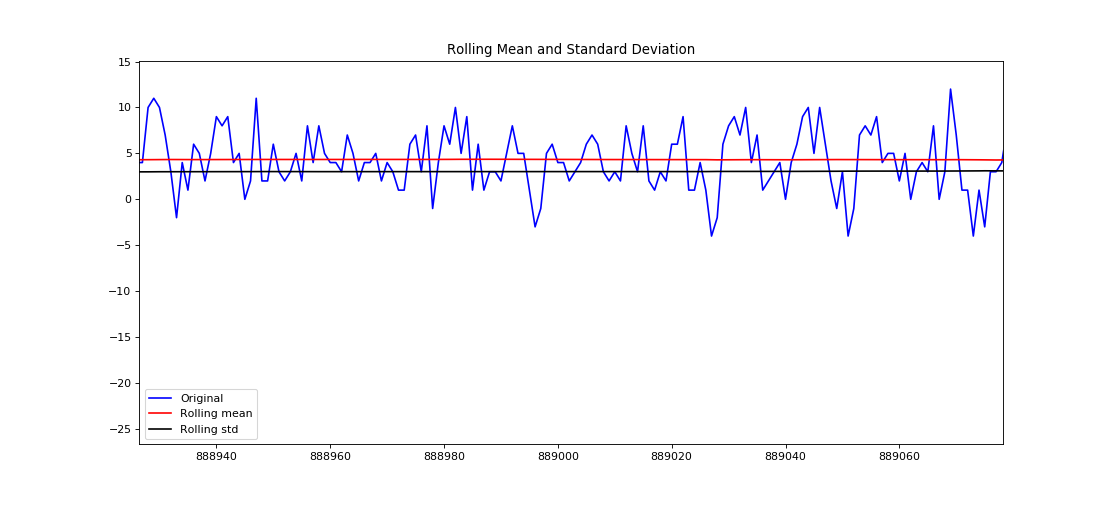

In [7]:
rolmean = failure_reduced_1[['acoustic_data']].rolling(1000).mean()
rolstd = failure_reduced_1[['acoustic_data']].rolling(1000).std()

orig = plt.plot(failure_reduced_1[['acoustic_data']], color='orange', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling mean')
rolstd = plt.plot(rolstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

Auch visuell bestätigt sich die Annahme, dass das Signal keine Trendkomponente enthaltet.

#### Prepare data for windows plot

In [5]:
failure_2 = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(1)))
failure_2.columns = ['acoustic_data','time_to_failure']
failure_reduced_2 = failure_2.iloc[::2, :] 
failure_reduced_2.reset_index(inplace=True)

In [4]:
window = 5000 #willkürlich gewählt --> sollte noch besprochen werden!

<IPython.core.display.Javascript object>


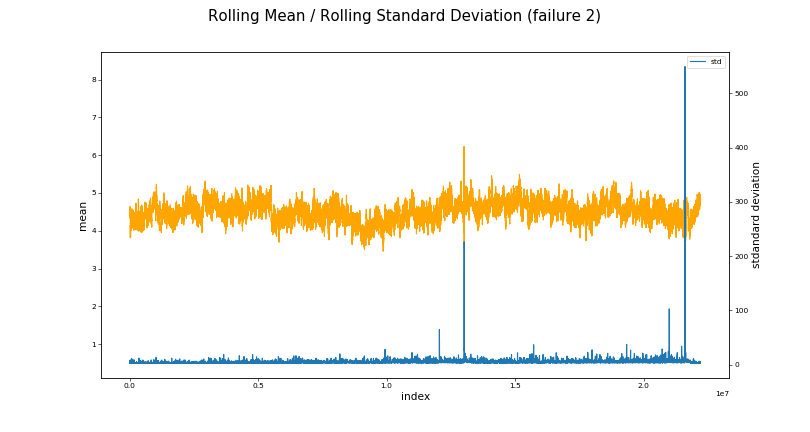

In [25]:
fig, ax1 = plt.subplots(figsize=(15, 8))
fig.suptitle('Rolling Mean / Rolling Standard Deviation (failure 2)', fontsize=20)

ax2 = ax1.twinx()
ax1.set_xlabel('index', fontsize=14)
ax1.set_ylabel('mean', fontsize=14)
ax2.set_ylabel('stdandard deviation', fontsize=14)
    
ax1.plot(failure_reduced_2[['acoustic_data']].rolling(window).mean(), label='mean', color='orange')
ax2.plot(failure_reduced_2[['acoustic_data']].rolling(window).std(), label='std')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


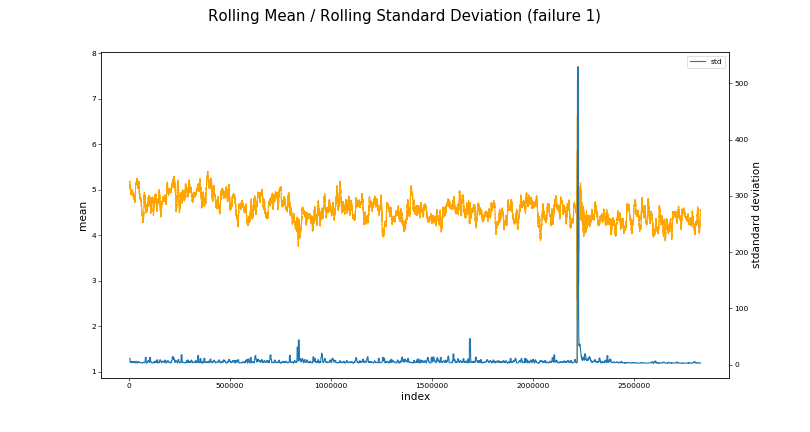

In [35]:
fig, ax1 = plt.subplots(figsize=(15, 8))
fig.suptitle('Rolling Mean / Rolling Standard Deviation (failure 1)', fontsize=20)

ax2 = ax1.twinx()
ax1.set_xlabel('index', fontsize=14)
ax1.set_ylabel('mean', fontsize=14)
ax2.set_ylabel('stdandard deviation', fontsize=14)
    
ax1.plot(failure_reduced_1[['acoustic_data']].rolling(window).mean(), label='mean', color='orange')
ax2.plot(failure_reduced_1[['acoustic_data']].rolling(window).std(), label='std')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


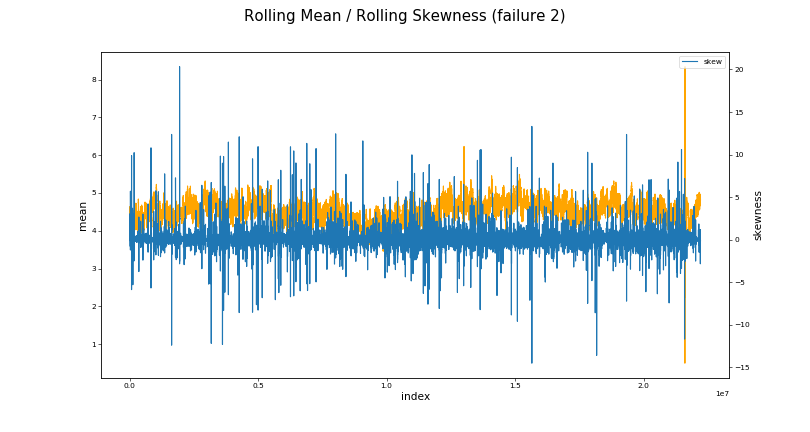

In [26]:
fig, ax1 = plt.subplots(figsize=(15, 8))
fig.suptitle('Rolling Mean / Rolling Skewness (failure 2)', fontsize=20)

ax2 = ax1.twinx()
ax1.set_xlabel('index',fontsize=14)
ax1.set_ylabel('mean',fontsize=14)
ax2.set_ylabel('skewness',fontsize=14)
    
ax1.plot(failure_reduced_2[['acoustic_data']].rolling(window).mean(), label='mean', color='orange')
ax2.plot(failure_reduced_2[['acoustic_data']].rolling(window).skew(), label='skew',)
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


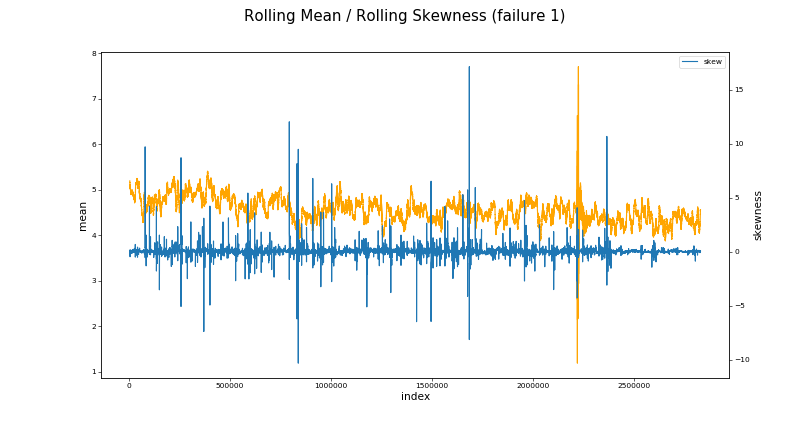

In [34]:
fig, ax1 = plt.subplots(figsize=(15, 8))
fig.suptitle('Rolling Mean / Rolling Skewness (failure 1)', fontsize=20)

ax2 = ax1.twinx()
ax1.set_xlabel('index',fontsize=14)
ax1.set_ylabel('mean',fontsize=14)
ax2.set_ylabel('skewness',fontsize=14)
    
ax1.plot(failure_reduced_1[['acoustic_data']].rolling(window).mean(), label='mean', color='orange')
ax2.plot(failure_reduced_1[['acoustic_data']].rolling(window).skew(), label='skew',)
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


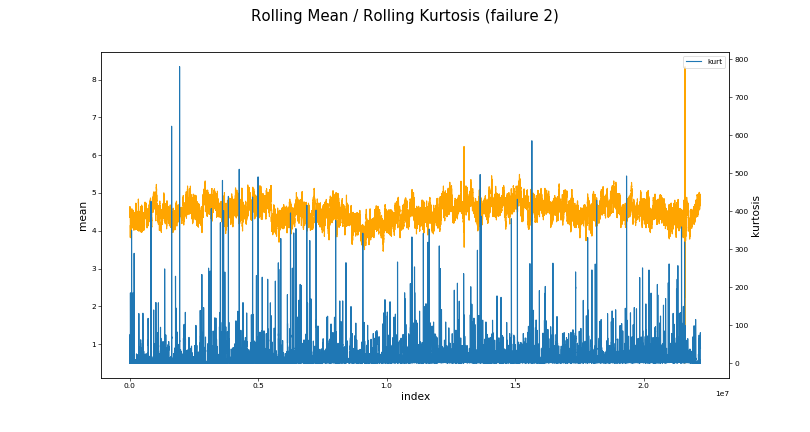

In [27]:
fig, ax1 = plt.subplots(figsize=(15, 8))
fig.suptitle('Rolling Mean / Rolling Kurtosis (failure 2)', fontsize=20)

ax2 = ax1.twinx()
ax1.set_xlabel('index',fontsize=14)
ax1.set_ylabel('mean',fontsize=14)
ax2.set_ylabel('kurtosis',fontsize=14)
    
ax1.plot(failure_reduced_2[['acoustic_data']].rolling(window).mean(), label='mean', color='orange')
ax2.plot(failure_reduced_2[['acoustic_data']].rolling(window).kurt(), label='kurt')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


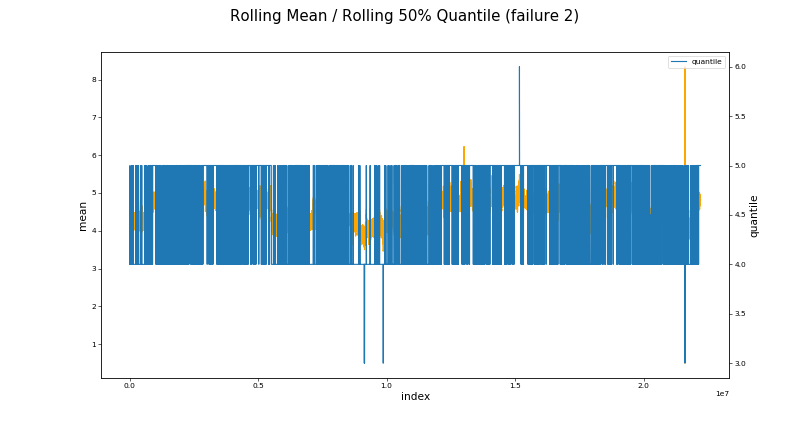

In [28]:
fig, ax1 = plt.subplots(figsize=(15, 8))
fig.suptitle('Rolling Mean / Rolling 50% Quantile (failure 2)', fontsize=20)

ax2 = ax1.twinx()
ax1.set_xlabel('index',fontsize=14)
ax1.set_ylabel('mean',fontsize=14)
ax2.set_ylabel('quantile',fontsize=14)
    
ax1.plot(failure_reduced_2[['acoustic_data']].rolling(window).mean(), label='mean', color='orange')
ax2.plot(failure_reduced_2[['acoustic_data']].rolling(window).quantile(.5, interpolation='midpoint'), label='quantile')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


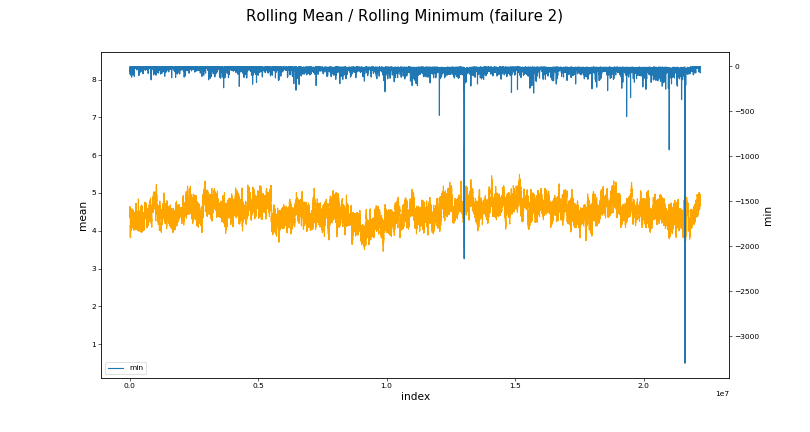

In [29]:
fig, ax1 = plt.subplots(figsize=(15, 8))
fig.suptitle('Rolling Mean / Rolling Minimum (failure 2)', fontsize=20)

ax2 = ax1.twinx()
ax1.set_xlabel('index',fontsize=14)
ax1.set_ylabel('mean',fontsize=14)
ax2.set_ylabel('min',fontsize=14)
    
ax1.plot(failure_reduced_2[['acoustic_data']].rolling(window).mean(), label='mean', color='orange')
ax2.plot(failure_reduced_2[['acoustic_data']].rolling(window).min(), label='min')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


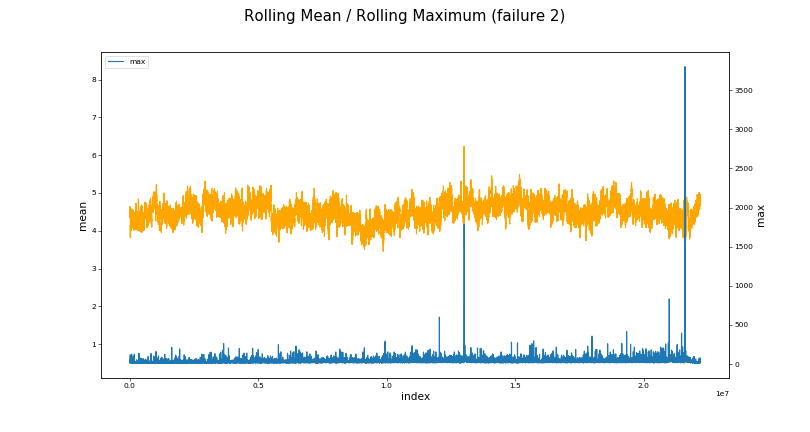

In [30]:
fig, ax1 = plt.subplots(figsize=(15, 8))
fig.suptitle('Rolling Mean / Rolling Maximum (failure 2)', fontsize=20)

ax2 = ax1.twinx()
ax1.set_xlabel('index',fontsize=14)
ax1.set_ylabel('mean',fontsize=14)
ax2.set_ylabel('max',fontsize=14)
    
ax1.plot(failure_reduced_2[['acoustic_data']].rolling(window).mean(), label='mean', color='orange')
ax2.plot(failure_reduced_2[['acoustic_data']].rolling(window).max(), label='max')
plt.legend(loc='best')
plt.show()

## Autokorrelationen

In [11]:
print(acf(failure_reduced[0], nlags=100, fft=True))

[ 1.00000000e+00  3.69175691e-01 -2.96095504e-01 -2.72881204e-01
 -1.93279104e-01 -6.75089263e-02  1.47335858e-01 -8.98929590e-02
 -3.69069775e-01 -1.11024147e-01  2.04387544e-01  2.04102812e-01
  1.21463533e-01 -2.54623824e-02 -1.91395940e-01 -4.51759916e-02
  1.88686574e-01  1.17384884e-01 -5.83207685e-02 -1.02632890e-01
 -7.10223008e-02  3.03321504e-02  1.14718457e-01  5.62534381e-02
 -5.52428742e-02 -6.50646331e-02 -5.29887153e-03  3.38813572e-02
 -1.89236403e-02 -1.19745083e-01 -1.45656789e-01 -1.51072114e-02
  1.59789340e-01  2.12189733e-01  1.17753599e-01 -2.84725787e-02
 -1.07169184e-01 -6.96796212e-02 -3.43818214e-03 -1.27884699e-02
 -8.03382786e-02 -1.20892937e-01 -1.59513235e-02  1.37538742e-01
  1.58195024e-01  4.90341396e-02 -4.76586420e-02 -7.02205035e-02
 -4.81552434e-03  5.71166870e-02  9.20451547e-03 -8.26674262e-02
 -9.48430345e-02 -2.76077315e-02  4.64456035e-02  8.41504477e-02
  4.21158653e-02 -1.74763768e-02 -3.84746305e-03  3.32590060e-02
 -2.99960262e-03 -5.37891

<IPython.core.display.Javascript object>


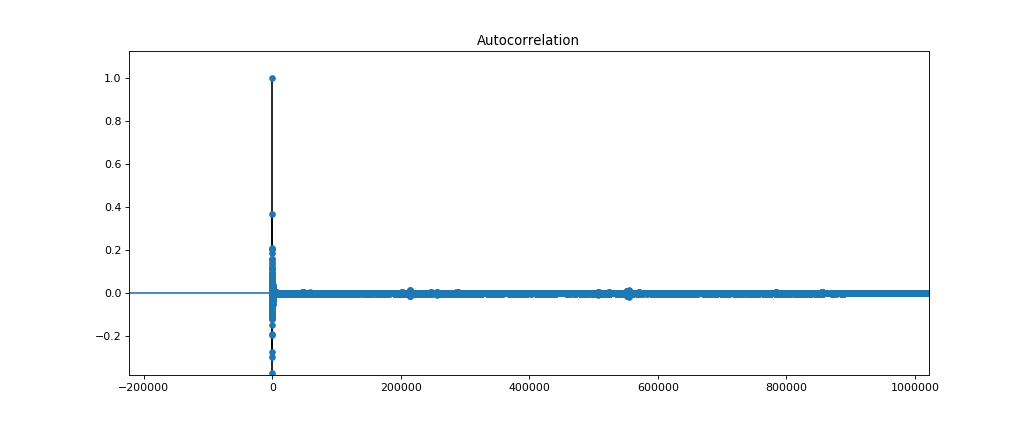

In [71]:
plot_acf(failure_reduced.acoustic_data,alpha=0.05,lags=1000)
plt.show()